In [18]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy.signal import resample
from keras.layers import *
import keras
from keras.models import Model
from keras.optimizers import Adam,Adadelta,Adagrad,RMSprop,Adamax,SGD
#尝试了这么多优化器还是Adam比较好
from keras.utils import to_categorical
from sklearn.model_selection import StratifiedKFold
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import math
import math
from sklearn.utils import class_weight
from keras_layer_normalization import LayerNormalization

In [2]:
train = pd.read_csv('data/sensor_train.csv')
test = pd.read_csv('data/sensor_test.csv')
sub = pd.read_csv('提交结果示例.csv')
y = train.groupby('fragment_id')['behavior_id'].min()

In [3]:
train['mod'] = (train.acc_x ** 2 + train.acc_y ** 2 + train.acc_z ** 2) ** .5
train['modg'] = (train.acc_xg ** 2 + train.acc_yg ** 2 + train.acc_zg ** 2) ** .5
test['mod'] = (test.acc_x ** 2 + test.acc_y ** 2 + test.acc_z ** 2) ** .5
test['modg'] = (test.acc_xg ** 2 + test.acc_yg ** 2 + test.acc_zg ** 2) ** .5

In [4]:
#角度特征
def arccos(x):
    return math.acos(x)

for x in ['acc_xg', 'acc_yg', 'acc_zg']:
    #train['acos_'+x] =  train.apply(lambda row: (math.pi-arccos(-row[x]/row['modg']))*180, axis=1)
    train['acos_'+x] =  train.apply(lambda row: arccos(row[x]/row['modg']) , axis=1)

for x in ['acc_xg', 'acc_yg', 'acc_zg']:
    #test['acos_'+x]=  test.apply(lambda row: (math.pi-arccos(-row[x]/row['modg']))*180, axis=1)
    test['acos_'+x]=  test.apply(lambda row: arccos(row[x]/row['modg']) , axis=1)
    


In [5]:
 #加入角度特征都可以在0.75以上，不管是余弦值还是角度

In [6]:
data = pd.concat([train , test], sort=False) #默认拼接到下面axis=0

In [29]:
data.head()

,fragment_id,time_point,acc_x,acc_y,acc_z,acc_xg,acc_yg,acc_zg,behavior_id,mod,modg,acos_acc_xg,acos_acc_yg,acos_acc_zg
0,0,27,0.3,-0.3,0.1,0.6,4.5,8.8,0.0,0.435890,9.902020,1.510165,1.099039,0.476278
1,0,108,0.1,-0.0,-0.4,0.4,4.7,8.4,0.0,0.412311,9.633795,1.529264,1.061153,0.511665
2,0,198,0.1,0.0,0.3,0.9,4.6,9.0,0.0,0.316228,10.147413,1.481987,1.100313,0.480150
3,0,297,0.1,-0.1,-0.5,0.8,4.7,7.2,0.0,0.519615,8.635392,1.478021,0.995276,0.584881
4,0,388,0.1,0.2,0.6,0.9,4.7,8.9,0.0,0.640312,10.104949,1.481613,1.087028,0.493339


In [30]:
# 使用训练集和测试集的数据一起进行标准化
def feature_normalize(x,i):
    mu = np.mean(data[i], axis=0)
    sigma = np.std(data[i], axis=0)
    return (x - mu) / sigma
for i in [x for x in train.columns if x not in ['behavior_id','fragment_id','time_point']]:
    train[i] = feature_normalize(train[i],i)
for i in [x for x in test.columns if x not in ['behavior_id','fragment_id','time_point']]:
    test[i] = feature_normalize(test[i],i)

# 2d数据

In [31]:
sample_len = 60
featrue_num = 11
# 60 0.708
# 70 0.715  其中一个0.72
# 
x = np.zeros((7292, sample_len, featrue_num))  #60,70
t = np.zeros((7500, sample_len, featrue_num))
for i in tqdm(range(7292)):
    tmp = train[train.fragment_id == i][:sample_len]
    x[i,:,:] = resample(tmp.drop(['fragment_id', 'time_point', 'behavior_id'],
                                    axis=1), sample_len, np.array(tmp.time_point))[0]
for i in tqdm(range(7500)):
    tmp = test[test.fragment_id == i][:sample_len]
    t[i,:,:] = resample(tmp.drop(['fragment_id', 'time_point'],
                                    axis=1), sample_len, np.array(tmp.time_point))[0]

100%|█████████████████████████████████████████████████████████████████████████████| 7500/7500 [00:13<00:00, 548.11it/s]


# 3d数据

In [9]:
sample_len = 61
featrue_num = 11
# 60 0.708
# 70 0.715  其中一个0.72
# 
x = np.zeros((7292, sample_len, featrue_num, 1))  #60,70
t = np.zeros((7500, sample_len, featrue_num, 1))
for i in tqdm(range(7292)):
    tmp = train[train.fragment_id == i][:sample_len]
    x[i,:,:, 0] = resample(tmp.drop(['fragment_id', 'time_point', 'behavior_id'],
                                    axis=1), sample_len, np.array(tmp.time_point))[0]
for i in tqdm(range(7500)):
    tmp = test[test.fragment_id == i][:sample_len]
    t[i,:,:, 0] = resample(tmp.drop(['fragment_id', 'time_point'],
                                    axis=1), sample_len, np.array(tmp.time_point))[0]

100%|█████████████████████████████████████████████████████████████████████████████| 7500/7500 [00:13<00:00, 570.96it/s]


In [ ]:
# 之前是先标准化再采样，
# 这里是先采样再标准化
# 标准化
for i in tqdm(range(11)):
    mean_s = np.mean(np.concatenate((x[:,:,i,0],t[:,:,i,0]),axis=0))
    sd_s = np.std(np.concatenate((x[:,:,i,0],t[:,:,i,0]),axis=0))
    x[:,:,i,0] = (x[:,:,i,0]-mean_s)/sd_s

for i in tqdm(range(11)):
    mean_s = np.mean(np.concatenate((x[:,:,i,0],t[:,:,i,0]),axis=0))
    sd_s = np.std(np.concatenate((x[:,:,i,0],t[:,:,i,0]),axis=0))
    t[:,:,i,0] = (t[:,:,i,0]-mean_s)/sd_s

# MLP

In [72]:
def Net():
    input = Input(shape=(60, 8)) #使用多通道
    X = Dense(64, activation='relu')(input)
    X = Dense(128, activation='relu')(X)
    X = Dense(256, activation='relu')(X)
    X = Dense(512, activation='relu')(X)
    X = Dense(512, activation='relu')(X)
    X = Flatten()(X)
    X = Dropout(0.3)(X)
    X = Dense(19, activation='softmax')(X)
    return Model([input], X)


# lstm

In [82]:


#model = Sequential()
def Net():
    input = Input(shape =(60,8))
    layer = LSTM(256, return_sequences=True)(input)
   # layer = GRU(256, return_sequences=True)(input)
    
    #layer = LSTM(512, return_sequences=True)(layer)
    layer = LSTM(256)(layer)
   
    layer = Dropout(0.5)(layer)
    X = Dense(19, activation='softmax')(layer)
    return Model([input], X)

In [10]:

def Net():
    input = Input(shape=(61, featrue_num, 1)) #使用多通道
    X = Conv2D(filters=64,
               kernel_size=(3, 3),
               activation='relu',
               padding='same')(input)
    X = Conv2D(filters=128,
               kernel_size=(3, 3),
               activation='relu',
               padding='same')(X)
    X = MaxPooling2D()(X)
    X = Dropout(0.2)(X)
    X = Conv2D(filters=256,
               kernel_size=(3, 3),
               activation='relu',
               padding='same')(X)
    X = Dropout(0.3)(X)
    X = Conv2D(filters=512,
               kernel_size=(3, 3),
               activation='relu',
               padding='same')(X)
    X = GlobalMaxPooling2D()(X)
    X = Dropout(0.5)(X)
    X = Dense(19, activation='softmax')(X)
    return Model([input], X)

# 0.75
"""
def Net():
    input = Input(shape=(60, 8, 1)) #使用多通道
    X = Conv2D(filters=64,
               kernel_size=(3, 3),
               activation='relu',
               padding='same')(input)
    X = Conv2D(filters=128,
               kernel_size=(3, 3),
               activation='relu',
               padding='same')(X)
    X = MaxPooling2D()(X)
    X = Conv2D(filters=256,
               kernel_size=(3, 3),
               activation='relu',
               padding='same')(X)
    X = Conv2D(filters=512,
               kernel_size=(3, 3),
               activation='relu',
               padding='same')(X)
    X = GlobalMaxPooling2D()(X)
    X = Dropout(0.3)(X)
    X = Dense(19, activation='softmax')(X)
    return Model([input], X)
"""
# 把GlobalMaxPooling2D 变成MaxPooling2D0.724
#best   使用全局标准化0.74 - 0.76

"""
def Net():
    input = Input(shape=(sample_len, featrue_num, 1))
    X = Conv2D(filters=64,
               kernel_size=(3, 3),
               activation='relu',
               padding='same')(input)
    X = Conv2D(filters=128,
               kernel_size=(3, 3),
               activation='relu',
               padding='same')(X)
    X = MaxPooling2D()(X)
    X = Dropout(0.5)(X)
    X = Conv2D(filters=256,
               kernel_size=(3, 3),
               activation='relu',
               padding='same')(X)
    X = Conv2D(filters=512,
               kernel_size=(3, 3),
               activation='relu',
               padding='same')(X)
    #X = GlobalMaxPooling2D()(X)
    print(X.shape)
    X = Permute((1,3,2))(X)#35, 4, 512
    X = MaxPooling2D(pool_size=(3,7))(X)
    X = Flatten()(X)
    X = Dropout(0.5)(X)
    X = Dense(19, activation='softmax')(X)
    return Model([input], X)
"""

"\ndef Net():\n    input = Input(shape=(sample_len, featrue_num, 1))\n    X = Conv2D(filters=64,\n               kernel_size=(3, 3),\n               activation='relu',\n               padding='same')(input)\n    X = Conv2D(filters=128,\n               kernel_size=(3, 3),\n               activation='relu',\n               padding='same')(X)\n    X = MaxPooling2D()(X)\n    X = Dropout(0.5)(X)\n    X = Conv2D(filters=256,\n               kernel_size=(3, 3),\n               activation='relu',\n               padding='same')(X)\n    X = Conv2D(filters=512,\n               kernel_size=(3, 3),\n               activation='relu',\n               padding='same')(X)\n    #X = GlobalMaxPooling2D()(X)\n    print(X.shape)\n    X = Permute((1,3,2))(X)#35, 4, 512\n    X = MaxPooling2D(pool_size=(3,7))(X)\n    X = Flatten()(X)\n    X = Dropout(0.5)(X)\n    X = Dense(19, activation='softmax')(X)\n    return Model([input], X)\n"

In [16]:
def BLOCK(seq, filters, kernal_size):
    cnn = keras.layers.Conv1D(filters, 1, padding='SAME', activation='relu')(seq)
    cnn = LayerNormalization()(cnn)

    cnn = keras.layers.Conv1D(filters, kernal_size, padding='SAME', activation='relu')(cnn)
    cnn = LayerNormalization()(cnn)

    cnn = keras.layers.Conv1D(filters, 1, padding='SAME', activation='relu')(cnn)
    cnn = LayerNormalization()(cnn)

    seq = keras.layers.Conv1D(filters, 1)(seq)
    seq = keras.layers.Add()([seq, cnn])
    return seq

def BLOCK2(seq, filters=128, kernal_size=5):
    seq = BLOCK(seq, filters, kernal_size)
    seq = keras.layers.MaxPooling1D(2)(seq)
    seq = keras.layers.SpatialDropout1D(0.3)(seq)
    seq = BLOCK(seq, filters//2, kernal_size)
    seq = keras.layers.GlobalAveragePooling1D()(seq)
    return seq

def Net():
    inputs = keras.layers.Input(shape=(60,11))
    seq_3 = BLOCK2(inputs, kernal_size=3)
    seq_5 = BLOCK2(inputs, kernal_size=5)
    seq_7 = BLOCK2(inputs, kernal_size=7)
    seq = keras.layers.concatenate([seq_3, seq_5, seq_7])
    seq = keras.layers.Dense(512, activation='relu')(seq)
    seq = keras.layers.Dropout(0.3)(seq)
    seq = keras.layers.Dense(128, activation='relu')(seq)
    seq = keras.layers.Dropout(0.3)(seq)
    outputs = keras.layers.Dense(19, activation='softmax')(seq)

    model = keras.models.Model(inputs=[inputs], outputs=[outputs])


    return model

# Resnte

In [ ]:
def ResNet():
    main_input = Input(shape=(60, 6))
    x = K.expand_dims(main_input, -1)  #扩展为
    x = Conv2D(filters=32, kernel_size=[7,1], strides=(2,1),padding="same",data_format='channels_last')(x)
    x = BatchNormalization()(x)
    x = Activation('relu', name="relu")(x)
    x = block1(x,32,kernel_size=[5,1],srides=(1,2),repeat=1)
    
    x1 = block2(x,out_channels,kernel_size=[2,1],srides=(2,1),repeat=3)
    x2 = block2(x,out_channels,kernel_size=[3,1],srides=(2,1),repeat=3)
    x3 = block2(x,out_channels,kernel_size=[5,1],srides=(2,1),repeat=3)
    x1 = Reshape((x.shape[0],-1))(x1)
    x2 = Reshape((x.shape[0],-1))(x2)
    x3 = Reshape((x.shape[0],-1))(x3)
    x1 = block3(x1,256,kernel_size=2,srides=2,repeat=3)
    x2 = block3(x2,256,kernel_size=3,srides=2,repeat=3)
    x3 = block3(x3,256,kernel_size=5,srides=2,repeat=3)
    
    x1 = adapmaxpooling(x1,x1.shape[-1])
    x2 = adapmaxpooling(x2,x2.shape[-1])
    x3 = adapmaxpooling(x3,x3.shape[-1])
    x4 = Concatenate()([x1,x2,x3])
    
    model = Dense(19)(x4)
    model = BatchNormalization()(model)
    output = Activation('softmax', name="softmax")(model)
    model = Model(inputs=main_input, outputs=output)
    model.summary()  # 但因模型的
    return model

# 打印模型

In [19]:
model = Net()
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 60, 11)       0                                            
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 60, 128)      1536        input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_10 (Conv1D)              (None, 60, 128)      1536        input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_18 (Conv1D)              (None, 60, 128)      1536        input_2[0][0]                    
__________________________________________________________________________________________________
layer_norm

conv1d_15 (Conv1D)              (None, 30, 64)       20544       layer_normalization_11[0][0]     
__________________________________________________________________________________________________
conv1d_23 (Conv1D)              (None, 30, 64)       28736       layer_normalization_17[0][0]     
__________________________________________________________________________________________________
layer_normalization_6 (LayerNor (None, 30, 64)       128         conv1d_7[0][0]                   
__________________________________________________________________________________________________
layer_normalization_12 (LayerNo (None, 30, 64)       128         conv1d_15[0][0]                  
__________________________________________________________________________________________________
layer_normalization_18 (LayerNo (None, 30, 64)       128         conv1d_23[0][0]                  
__________________________________________________________________________________________________
conv1d_8 (

In [20]:
kfold = StratifiedKFold(5, shuffle=True,random_state=0)
#random_state 0 0.724   1994
# 2020

In [21]:
def smooth_labels(labels, factor=0.1):
    # smooth the labels
    labels *= (1 - factor)
    labels += (factor / labels.shape[1])

    # returned the smoothed labels
    return labels

In [22]:
def data_enhance(method, train_data, train_labels):
    # 加噪声进行数据增强
    if method == 'noise':
        noise = train_data + np.random.normal(0, 0.1, size=train_data.shape)
        train_labels  = smooth_labels(train_labels, factor=0.1)
        return noise, train_labels
    # 使用mixup进行数据增强
    elif method == 'mixup':
        index = [i for i in range(len(train_labels))]
        np.random.shuffle(index)

        x_mixup = np.zeros(train_data.shape)
        y_mixup = np.zeros(train_labels.shape)

        for i in range(len(train_labels)):
            x1 = train_data[i]
            x2 = train_data[index[i]]
            y1 = train_labels[i]
            y2 = train_labels[index[i]]

            factor = np.random.beta(0.2, 0.2)

            x_mixup[i] = x1 * factor + x2 * (1 - factor)
            y_mixup[i] = y1 * factor + y2 * (1 - factor)
            y_mixup = smooth_labels(y_mixup, factor=0.1)
        return x_mixup, y_mixup

In [23]:
def shuffle(data, labels, seed=None):
    index = [i for i in range(len(labels))]
    if seed != None:
        np.random.seed(seed)
    np.random.shuffle(index)
    return data[index], labels[index]

In [25]:
data_enhance_method = []# 'mixup''noise'

In [ ]:
from keras.losses import categorical_crossentropy

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (None, 60, 11)       0                                            
__________________________________________________________________________________________________
conv1d_146 (Conv1D)             (None, 60, 128)      1536        input_8[0][0]                    
__________________________________________________________________________________________________
conv1d_154 (Conv1D)             (None, 60, 128)      1536        input_8[0][0]                    
__________________________________________________________________________________________________
conv1d_162 (Conv1D)             (None, 60, 128)      1536        input_8[0][0]                    
__________________________________________________________________________________________________
layer_norm

conv1d_159 (Conv1D)             (None, 30, 64)       20544       layer_normalization_119[0][0]    
__________________________________________________________________________________________________
conv1d_167 (Conv1D)             (None, 30, 64)       28736       layer_normalization_125[0][0]    
__________________________________________________________________________________________________
layer_normalization_114 (LayerN (None, 30, 64)       128         conv1d_151[0][0]                 
__________________________________________________________________________________________________
layer_normalization_120 (LayerN (None, 30, 64)       128         conv1d_159[0][0]                 
__________________________________________________________________________________________________
layer_normalization_126 (LayerN (None, 30, 64)       128         conv1d_167[0][0]                 
__________________________________________________________________________________________________
conv1d_152

Epoch 29/100
 - 6s - loss: 1.2044 - acc: 0.7353 - val_loss: 1.2413 - val_acc: 0.7342
Epoch 30/100
 - 7s - loss: 1.1827 - acc: 0.7535 - val_loss: 1.2152 - val_acc: 0.7403
Epoch 31/100
 - 6s - loss: 1.1597 - acc: 0.7540 - val_loss: 1.2578 - val_acc: 0.7096
Epoch 32/100
 - 6s - loss: 1.1381 - acc: 0.7718 - val_loss: 1.2299 - val_acc: 0.7260
Epoch 33/100
 - 6s - loss: 1.1823 - acc: 0.7540 - val_loss: 1.2688 - val_acc: 0.7294
Epoch 34/100
 - 6s - loss: 1.1356 - acc: 0.7717 - val_loss: 1.2096 - val_acc: 0.7451
Epoch 35/100
 - 6s - loss: 1.1101 - acc: 0.7844 - val_loss: 1.1960 - val_acc: 0.7553
Epoch 36/100
 - 6s - loss: 1.1047 - acc: 0.7875 - val_loss: 1.1916 - val_acc: 0.7471
Epoch 37/100
 - 7s - loss: 1.0844 - acc: 0.8029 - val_loss: 1.1727 - val_acc: 0.7607
Epoch 38/100
 - 7s - loss: 1.0629 - acc: 0.8149 - val_loss: 1.1670 - val_acc: 0.7607
Epoch 39/100
 - 7s - loss: 1.0961 - acc: 0.7988 - val_loss: 1.1685 - val_acc: 0.7676
Epoch 40/100
 - 7s - loss: 1.1023 - acc: 0.7880 - val_loss: 1.146

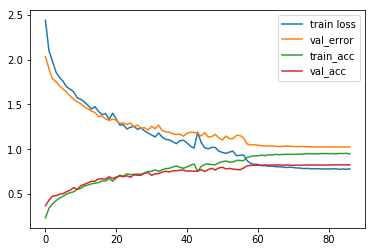

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 60, 11)       0                                            
__________________________________________________________________________________________________
conv1d_170 (Conv1D)             (None, 60, 128)      1536        input_9[0][0]                    
__________________________________________________________________________________________________
conv1d_178 (Conv1D)             (None, 60, 128)      1536        input_9[0][0]                    
__________________________________________________________________________________________________
conv1d_186 (Conv1D)             (None, 60, 128)      1536        input_9[0][0]                    
__________________________________________________________________________________________________
layer_norm

conv1d_183 (Conv1D)             (None, 30, 64)       20544       layer_normalization_137[0][0]    
__________________________________________________________________________________________________
conv1d_191 (Conv1D)             (None, 30, 64)       28736       layer_normalization_143[0][0]    
__________________________________________________________________________________________________
layer_normalization_132 (LayerN (None, 30, 64)       128         conv1d_175[0][0]                 
__________________________________________________________________________________________________
layer_normalization_138 (LayerN (None, 30, 64)       128         conv1d_183[0][0]                 
__________________________________________________________________________________________________
layer_normalization_144 (LayerN (None, 30, 64)       128         conv1d_191[0][0]                 
__________________________________________________________________________________________________
conv1d_176

Epoch 29/100
 - 20s - loss: 1.1828 - acc: 0.7448 - val_loss: 1.2229 - val_acc: 0.7467
Epoch 30/100
 - 21s - loss: 1.1672 - acc: 0.7549 - val_loss: 1.2075 - val_acc: 0.7467
Epoch 31/100
 - 20s - loss: 1.1523 - acc: 0.7711 - val_loss: 1.1778 - val_acc: 0.7604
Epoch 32/100
 - 21s - loss: 1.1429 - acc: 0.7662 - val_loss: 1.2033 - val_acc: 0.7440
Epoch 33/100
 - 22s - loss: 1.1272 - acc: 0.7817 - val_loss: 1.2071 - val_acc: 0.7406
Epoch 34/100
 - 21s - loss: 1.1177 - acc: 0.7807 - val_loss: 1.2041 - val_acc: 0.7529
Epoch 35/100
 - 20s - loss: 1.0976 - acc: 0.7884 - val_loss: 1.1755 - val_acc: 0.7577
Epoch 36/100
 - 20s - loss: 1.1027 - acc: 0.7920 - val_loss: 1.1693 - val_acc: 0.7721
Epoch 37/100
 - 21s - loss: 1.1002 - acc: 0.7925 - val_loss: 1.1565 - val_acc: 0.7864
Epoch 38/100
 - 20s - loss: 1.0688 - acc: 0.8031 - val_loss: 1.1635 - val_acc: 0.7728
Epoch 39/100
 - 20s - loss: 1.0521 - acc: 0.8098 - val_loss: 1.1528 - val_acc: 0.7762
Epoch 40/100
 - 21s - loss: 1.0427 - acc: 0.8194 - val

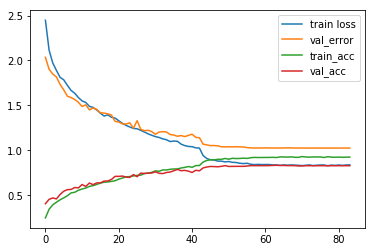

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           (None, 60, 11)       0                                            
__________________________________________________________________________________________________
conv1d_194 (Conv1D)             (None, 60, 128)      1536        input_10[0][0]                   
__________________________________________________________________________________________________
conv1d_202 (Conv1D)             (None, 60, 128)      1536        input_10[0][0]                   
__________________________________________________________________________________________________
conv1d_210 (Conv1D)             (None, 60, 128)      1536        input_10[0][0]                   
__________________________________________________________________________________________________
layer_norm

conv1d_207 (Conv1D)             (None, 30, 64)       20544       layer_normalization_155[0][0]    
__________________________________________________________________________________________________
conv1d_215 (Conv1D)             (None, 30, 64)       28736       layer_normalization_161[0][0]    
__________________________________________________________________________________________________
layer_normalization_150 (LayerN (None, 30, 64)       128         conv1d_199[0][0]                 
__________________________________________________________________________________________________
layer_normalization_156 (LayerN (None, 30, 64)       128         conv1d_207[0][0]                 
__________________________________________________________________________________________________
layer_normalization_162 (LayerN (None, 30, 64)       128         conv1d_215[0][0]                 
__________________________________________________________________________________________________
conv1d_200

Epoch 29/100
 - 20s - loss: 1.1811 - acc: 0.7544 - val_loss: 1.2569 - val_acc: 0.7140
Epoch 30/100
 - 20s - loss: 1.0841 - acc: 0.8013 - val_loss: 1.1610 - val_acc: 0.7661
Epoch 31/100
 - 20s - loss: 1.0458 - acc: 0.8181 - val_loss: 1.1505 - val_acc: 0.7730
Epoch 32/100
 - 20s - loss: 1.0332 - acc: 0.8248 - val_loss: 1.1393 - val_acc: 0.7743
Epoch 33/100
 - 20s - loss: 1.0271 - acc: 0.8217 - val_loss: 1.1347 - val_acc: 0.7785
Epoch 34/100
 - 20s - loss: 1.0147 - acc: 0.8315 - val_loss: 1.1281 - val_acc: 0.7805
Epoch 35/100
 - 20s - loss: 1.0111 - acc: 0.8344 - val_loss: 1.1274 - val_acc: 0.7771
Epoch 36/100
 - 20s - loss: 1.0008 - acc: 0.8401 - val_loss: 1.1263 - val_acc: 0.7853
Epoch 37/100
 - 20s - loss: 0.9991 - acc: 0.8348 - val_loss: 1.1227 - val_acc: 0.7908
Epoch 38/100
 - 20s - loss: 0.9882 - acc: 0.8450 - val_loss: 1.1212 - val_acc: 0.7798
Epoch 39/100
 - 20s - loss: 0.9776 - acc: 0.8454 - val_loss: 1.1159 - val_acc: 0.7881
Epoch 40/100
 - 20s - loss: 0.9770 - acc: 0.8608 - val

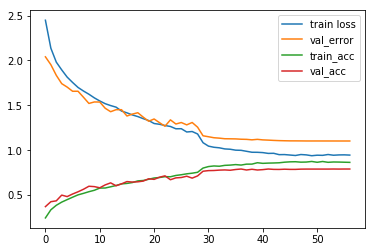

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 60, 11)       0                                            
__________________________________________________________________________________________________
conv1d_218 (Conv1D)             (None, 60, 128)      1536        input_11[0][0]                   
__________________________________________________________________________________________________
conv1d_226 (Conv1D)             (None, 60, 128)      1536        input_11[0][0]                   
__________________________________________________________________________________________________
conv1d_234 (Conv1D)             (None, 60, 128)      1536        input_11[0][0]                   
__________________________________________________________________________________________________
layer_norm

conv1d_231 (Conv1D)             (None, 30, 64)       20544       layer_normalization_173[0][0]    
__________________________________________________________________________________________________
conv1d_239 (Conv1D)             (None, 30, 64)       28736       layer_normalization_179[0][0]    
__________________________________________________________________________________________________
layer_normalization_168 (LayerN (None, 30, 64)       128         conv1d_223[0][0]                 
__________________________________________________________________________________________________
layer_normalization_174 (LayerN (None, 30, 64)       128         conv1d_231[0][0]                 
__________________________________________________________________________________________________
layer_normalization_180 (LayerN (None, 30, 64)       128         conv1d_239[0][0]                 
__________________________________________________________________________________________________
conv1d_224

Epoch 29/100
 - 7s - loss: 1.1620 - acc: 0.7610 - val_loss: 1.2707 - val_acc: 0.7093
Epoch 30/100
 - 7s - loss: 1.1558 - acc: 0.7619 - val_loss: 1.2085 - val_acc: 0.7402
Epoch 31/100
 - 7s - loss: 1.1298 - acc: 0.7744 - val_loss: 1.3095 - val_acc: 0.7100
Epoch 32/100
 - 7s - loss: 1.1368 - acc: 0.7692 - val_loss: 1.2247 - val_acc: 0.7519
Epoch 33/100
 - 7s - loss: 1.1063 - acc: 0.7912 - val_loss: 1.2410 - val_acc: 0.7354
Epoch 34/100
 - 7s - loss: 1.0988 - acc: 0.7970 - val_loss: 1.2468 - val_acc: 0.7368
Epoch 35/100
 - 7s - loss: 1.0951 - acc: 0.7924 - val_loss: 1.2125 - val_acc: 0.7430
Epoch 36/100
 - 7s - loss: 1.0641 - acc: 0.8059 - val_loss: 1.2193 - val_acc: 0.7540
Epoch 37/100
 - 7s - loss: 1.0508 - acc: 0.8124 - val_loss: 1.1501 - val_acc: 0.7704
Epoch 38/100
 - 8s - loss: 1.0390 - acc: 0.8211 - val_loss: 1.2158 - val_acc: 0.7478
Epoch 39/100
 - 7s - loss: 1.0342 - acc: 0.8234 - val_loss: 1.1755 - val_acc: 0.7684
Epoch 40/100
 - 7s - loss: 1.0319 - acc: 0.8289 - val_loss: 1.184

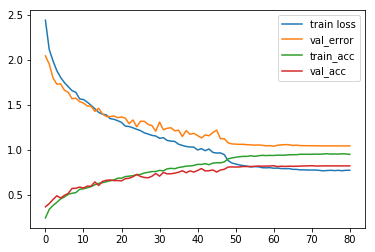

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           (None, 60, 11)       0                                            
__________________________________________________________________________________________________
conv1d_242 (Conv1D)             (None, 60, 128)      1536        input_12[0][0]                   
__________________________________________________________________________________________________
conv1d_250 (Conv1D)             (None, 60, 128)      1536        input_12[0][0]                   
__________________________________________________________________________________________________
conv1d_258 (Conv1D)             (None, 60, 128)      1536        input_12[0][0]                   
__________________________________________________________________________________________________
layer_norm

conv1d_255 (Conv1D)             (None, 30, 64)       20544       layer_normalization_191[0][0]    
__________________________________________________________________________________________________
conv1d_263 (Conv1D)             (None, 30, 64)       28736       layer_normalization_197[0][0]    
__________________________________________________________________________________________________
layer_normalization_186 (LayerN (None, 30, 64)       128         conv1d_247[0][0]                 
__________________________________________________________________________________________________
layer_normalization_192 (LayerN (None, 30, 64)       128         conv1d_255[0][0]                 
__________________________________________________________________________________________________
layer_normalization_198 (LayerN (None, 30, 64)       128         conv1d_263[0][0]                 
__________________________________________________________________________________________________
conv1d_248

Epoch 29/100
 - 7s - loss: 1.1641 - acc: 0.7661 - val_loss: 1.2456 - val_acc: 0.7085
Epoch 30/100
 - 7s - loss: 1.1449 - acc: 0.7713 - val_loss: 1.2303 - val_acc: 0.7271
Epoch 31/100
 - 7s - loss: 1.1349 - acc: 0.7694 - val_loss: 1.2583 - val_acc: 0.7064
Epoch 32/100
 - 7s - loss: 1.1408 - acc: 0.7696 - val_loss: 1.2186 - val_acc: 0.7326
Epoch 33/100
 - 7s - loss: 1.0360 - acc: 0.8226 - val_loss: 1.1061 - val_acc: 0.7753
Epoch 34/100
 - 7s - loss: 0.9965 - acc: 0.8375 - val_loss: 1.0955 - val_acc: 0.7815
Epoch 35/100
 - 7s - loss: 0.9747 - acc: 0.8543 - val_loss: 1.0878 - val_acc: 0.7864
Epoch 36/100
 - 7s - loss: 0.9696 - acc: 0.8552 - val_loss: 1.0860 - val_acc: 0.7884
Epoch 37/100
 - 7s - loss: 0.9628 - acc: 0.8577 - val_loss: 1.0858 - val_acc: 0.7877
Epoch 38/100
 - 7s - loss: 0.9550 - acc: 0.8570 - val_loss: 1.0832 - val_acc: 0.7870
Epoch 39/100
 - 7s - loss: 0.9480 - acc: 0.8625 - val_loss: 1.0713 - val_acc: 0.7946
Epoch 40/100
 - 7s - loss: 0.9432 - acc: 0.8661 - val_loss: 1.071

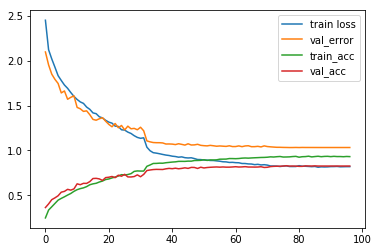

In [33]:
proba_t = np.zeros((7500, 19))
#标签平滑

#y_ = to_categorical(y, num_classes=19)

for fold, (xx, yy) in enumerate(kfold.split(x, y)):
    y_ = to_categorical(y, num_classes=19)
    y_ = smooth_labels(y_,factor=0.1)
    model = Net()
    model.summary()
    model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(),#Adadelta
                  metrics=['acc'])
    plateau = ReduceLROnPlateau(monitor="val_acc",#val_loss
                                verbose=0,
                                mode='max',#‘auto’，‘min’，‘max’之一，在min模式下，如果检测值触发学习率减少。在max模式下，当检测值不再上升则触发学习率减少。
                                factor=0.1,#lr = lr*factor的形式被减少  0.1和0.02都可以
                                patience=6)
    early_stopping = EarlyStopping(monitor='val_acc',
                                   verbose=0,
                                   mode='max',
                                   patience=20)
    checkpoint = ModelCheckpoint('fold'+str(fold)+'.h5',
                                 monitor='val_acc',
                                 verbose=0,
                                 mode='max',
                                 save_best_only=True)
    my_class_weight = class_weight.compute_class_weight('balanced'
                                          ,np.unique(np.argmax(y_[xx],axis=-1))
                                          ,np.argmax(y_[xx],axis=-1)).tolist()
    
    # 需要转成字典
    class_weight_dict = dict(zip([x for x in np.unique(np.argmax(y_[xx],axis=-1))], my_class_weight))
    
    x_train = x[xx]
    y_train = y_[xx]

    if len(data_enhance_method) > 0:
        x_train_copy = np.copy(x_train)
        y_train_copy = np.copy(y_train)
        for method in data_enhance_method:
            x_t, y_t = data_enhance(method, x_train_copy, y_train_copy)
            x_train = np.r_[x_train, x_t]
            y_train = np.r_[y_train, y_t]
        x_train, y_train = shuffle(x_train, y_train)
        print('Data enhanced (%s) => %d' % (' '.join(data_enhance_method), len(x_train)))

    #class_weight=class_weight_dict
    history = model.fit(x_train, y_train,
              epochs=100,
              batch_size=32,#128,256,512,更小的64 0.724
              verbose=2,
              shuffle=True,
              validation_data=(x[yy], y_[yy]),
              callbacks=[plateau, early_stopping, checkpoint],
                        class_weight=class_weight_dict)
    y_true = np.argmax(y_[yy],axis=-1)

    y_pred = np.argmax(model.predict(x[yy], verbose=0, batch_size=1024),axis=-1)
    print("classification report:\n")
    print(classification_report(y_true, y_pred))
    model.load_weights('fold'+str(fold)+'.h5')
    proba_t += model.predict(t, verbose=0, batch_size=1024) / 5.
    plt.plot(history.epoch, history.history['loss'], label='train loss')
    plt.plot(history.epoch, history.history['val_loss'], label='val_error')
    plt.plot(history.epoch, history.history['acc'],label='train_acc')
    plt.plot(history.epoch, history.history['val_acc'], label = 'val_acc')
    plt.legend()
    plt.show()
    


In [56]:
sub.behavior_id = np.argmax(proba_t, axis=1)
sub.to_csv('提交结果示例.csv', index=False)sub_probs = ['prob_{}'.format(q) for q in range(19)]
prob_df = pd.DataFrame(proba_t, columns=sub_probs)
result = pd.concat([sub['fragm
#0.72 0.72 0.71 0.68

In [34]:
sub_probs = ['prob_{}'.format(q) for q in range(19)]
prob_df = pd.DataFrame(proba_t, columns=sub_probs)
result = pd.concat([sub['fragment_id'],prob_df] , axis=1 )   #axis=1列增加 axis=0行增加 

#0.72 0.72 0.71 0.68

In [40]:
sub.behavior_id = np.argmax(proba_t, axis=1)
sub.to_csv('newcnn.csv', index=False)
result.to_csv('newcnnprob.csv', index=False)
#0.72 0.72 0.71 0.68

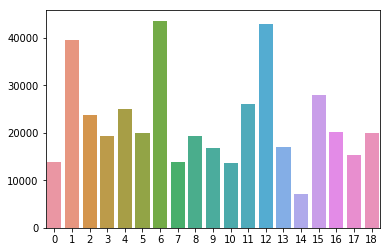

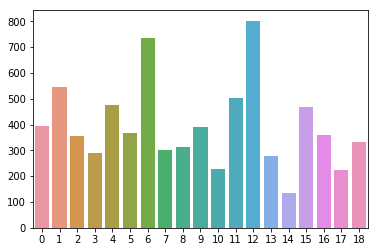

In [41]:
import seaborn as sns
vc = train['behavior_id'].value_counts().sort_index()
sns.barplot(vc.index, vc.values)
plt.show()
vc = sub['behavior_id'].value_counts().sort_index()
sns.barplot(vc.index, vc.values)
plt.show()

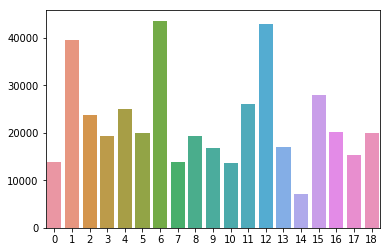

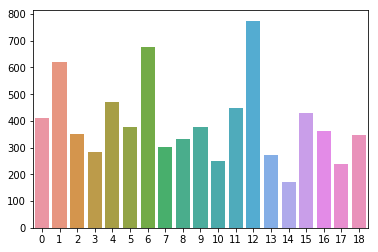

In [36]:
import seaborn as sns
vc = train['behavior_id'].value_counts().sort_index()
sns.barplot(vc.index, vc.values)
plt.show()
vc = sub['behavior_id'].value_counts().sort_index()
sns.barplot(vc.index, vc.values)
plt.show()

# 简单的加权融合

In [45]:
sub1 = pd.read_csv('noiseprob.csv').drop(columns = ['fragment_id'])
sub2 = pd.read_csv('pingyimixupprob.csv').drop(columns = ['fragment_id'])
sub3 = pd.read_csv('pingyiprob.csv').drop(columns = ['fragment_id'])
sub4 = pd.read_csv('0.775prob.csv').drop(columns = ['fragment_id'])
sub5 = pd.read_csv('newcnnprob.csv').drop(columns = ['fragment_id'])
proba = 0.768*sub1+0.7666*sub2+0.765*sub3+0.775*sub4+0.7743*sub5


In [46]:
### print(proba.shape)

sub = pd.read_csv('noise.csv')
print(sub.info())
sub.behavior_id = np.argmax(proba.values, axis=1)
sub.to_csv('rh.csv', index=False)
sub_probs = ['prob_{}'.format(q) for q in range(19)]
prob_df = pd.DataFrame(proba, columns=sub_probs)
result = pd.concat([sub['fragment_id'],prob_df] , axis=1 )   #axis=1列增加 axis=0行增加 
result.to_csv('rhprob.csv', index=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 2 columns):
fragment_id    7500 non-null int64
behavior_id    7500 non-null int64
dtypes: int64(2)
memory usage: 117.3 KB
None


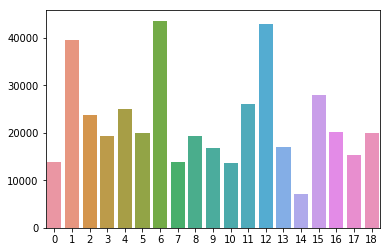

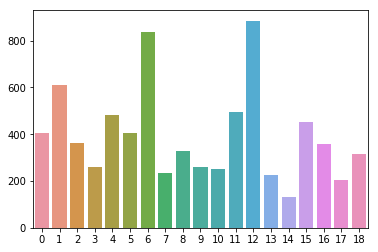

In [47]:
import seaborn as sns
vc = train['behavior_id'].value_counts().sort_index()
sns.barplot(vc.index, vc.values)
plt.show()
vc = sub['behavior_id'].value_counts().sort_index()
sns.barplot(vc.index, vc.values)
plt.show()

In [42]:
sub1 = pd.read_csv('newcnnprob.csv').drop(columns = ['fragment_id'])

sub2 = pd.read_csv('0.775prob.csv').drop(columns = ['fragment_id'])
sub3 = pd.read_csv('rhprob.csv').drop(columns = ['fragment_id'])
proba1 = 0.4*sub1+0.3*sub2+0.3*sub3


In [43]:
print(proba.shape)

sub = pd.read_csv('noise.csv')
print(sub.info())
sub.behavior_id = np.argmax(proba1.values, axis=1)
sub.to_csv('rh1.csv', index=False)
sub_probs = ['prob_{}'.format(q) for q in range(19)]
prob_df = pd.DataFrame(proba1, columns=sub_probs)
result = pd.concat([sub['fragment_id'],prob_df] , axis=1 )   #axis=1列增加 axis=0行增加 
result.to_csv('rh1prob.csv', index=False)

(7500, 19)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 2 columns):
fragment_id    7500 non-null int64
behavior_id    7500 non-null int64
dtypes: int64(2)
memory usage: 117.3 KB
None


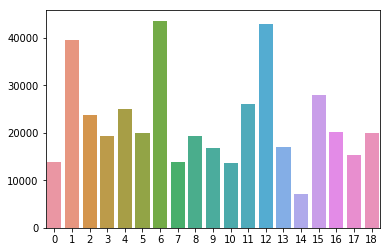

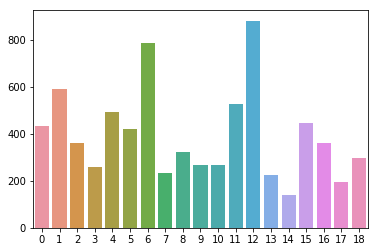

In [44]:
import seaborn as sns
vc = train['behavior_id'].value_counts().sort_index()
sns.barplot(vc.index, vc.values)
plt.show()
vc = sub['behavior_id'].value_counts().sort_index()
sns.barplot(vc.index, vc.values)
plt.show()

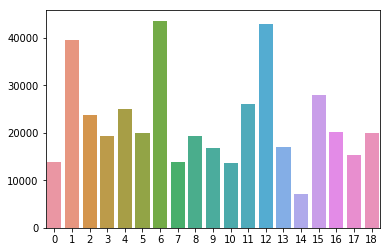

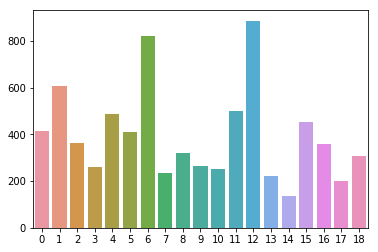

In [52]:
import seaborn as sns
vc = train['behavior_id'].value_counts().sort_index()
sns.barplot(vc.index, vc.values)
plt.show()
vc = sub['behavior_id'].value_counts().sort_index()
sns.barplot(vc.index, vc.values)
plt.show()

In [ ]:
 precision    recall  f1-score   support

           0       0.80      0.83      0.82        48
           1       0.76      0.76      0.76       135
           2       0.78      0.84      0.81        82
           3       0.79      0.66      0.72        67
           4       0.85      0.89      0.87        87
           5       0.77      0.74      0.76        69
           6       0.70      0.81      0.75       149
           7       0.85      0.62      0.72        47
           8       0.75      0.73      0.74        66
           9       0.76      0.59      0.66        58
          10       0.53      0.72      0.61        47
          11       0.82      0.80      0.81        90
          12       0.82      0.85      0.83       147
          13       0.61      0.62      0.62        58
          14       0.81      0.52      0.63        25
          15       0.74      0.75      0.75        96
          16       0.89      0.94      0.92        69
          17       0.79      0.65      0.72        52
          18       0.86      0.83      0.84        69

   micro avg       0.77      0.77      0.77      1461
   macro avg       0.77      0.74      0.75      1461
weighted avg       0.77      0.77      0.77      1461


precision    recall  f1-score   support

           0       0.67      0.69      0.68        48
           1       0.69      0.70      0.70       135
           2       0.84      0.76      0.79        82
           3       0.76      0.77      0.77        66
           4       0.85      0.91      0.88        87
           5       0.81      0.75      0.78        69
           6       0.64      0.74      0.69       148
           7       0.76      0.60      0.67        47
           8       0.77      0.82      0.79        66
           9       0.65      0.60      0.62        57
          10       0.76      0.66      0.70        47
          11       0.82      0.77      0.79        90
          12       0.76      0.88      0.82       147
          13       0.72      0.62      0.67        58
          14       0.67      0.56      0.61        25
          15       0.73      0.74      0.74        96
          16       0.88      0.99      0.93        69
          17       0.80      0.69      0.74        52
          18       0.84      0.74      0.78        69

   micro avg       0.76      0.76      0.76      1458
   macro avg       0.76      0.74      0.74      1458
weighted avg       0.76      0.76      0.75      1458


 precision    recall  f1-score   support

           0       0.74      0.77      0.76        48
           1       0.74      0.71      0.72       135
           2       0.80      0.78      0.79        82
           3       0.75      0.71      0.73        66
           4       0.86      0.92      0.89        87
           5       0.74      0.72      0.73        69
           6       0.66      0.76      0.71       148
           7       0.73      0.64      0.68        47
           8       0.79      0.80      0.80        66
           9       0.70      0.54      0.61        57
          10       0.68      0.64      0.66        47
          11       0.79      0.78      0.78        90
          12       0.79      0.91      0.85       147
          13       0.74      0.64      0.69        58
          14       0.78      0.56      0.65        25
          15       0.75      0.73      0.74        96
          16       0.93      0.97      0.95        69
          17       0.80      0.75      0.77        52
          18       0.85      0.80      0.82        69

   micro avg       0.77      0.77      0.77      1458
   macro avg       0.77      0.74      0.75      1458
weighted avg       0.77      0.77      0.76      1458



precision    recall  f1-score   support

           0       0.63      0.92      0.75        48
           1       0.82      0.83      0.83       135
           2       0.89      0.80      0.84        81
           3       0.87      0.80      0.83        66
           4       0.88      0.89      0.88        87
           5       0.82      0.72      0.77        68
           6       0.74      0.72      0.73       148
           7       0.76      0.74      0.75        47
           8       0.77      0.83      0.80        65
           9       0.58      0.53      0.55        57
          10       0.65      0.68      0.67        47
          11       0.84      0.80      0.82        89
          12       0.81      0.92      0.86       146
          13       0.83      0.67      0.74        58
          14       0.85      0.92      0.88        25
          15       0.80      0.71      0.75        95
          16       0.84      0.93      0.88        69
          17       0.80      0.73      0.76        51
          18       0.90      0.90      0.90        69

   micro avg       0.80      0.80      0.80      1451
   macro avg       0.79      0.79      0.79      1451
weighted avg       0.80      0.80      0.80      1451



